In [1]:
import numpy as np
from scipy.optimize import nnls
from matplotlib import pyplot as plt
from math import ceil

import demo_data

Our goal is to optimize the function $||AB - X||_F^2 + \lambda^2||Av-y||^2$ where $A,B$ are constrained to be non-negative while $v$ is not.

In [2]:
def matrix_nnls(A,X):
    
    '''Returns the non-negative matrix B which minimizes ||AB - X||^2'''
    
    m,k = A.shape
    m_,n = X.shape
    
    if m != m_:
        raise ValueError('First dimensions on inputs must match')
       
    X_cols = [X[:,i] for i in range(0,n)]
    nnls_by_col = [nnls(A, col)[0] for col in X_cols]
    return np.column_stack(nnls_by_col)

In [3]:
def do_training(X, y_vec, lmda, k, num_iters=100, return_loss_list = False):
    
    '''Iteratively minimizes $||AB - X||_F^2 + \lambda^2||Av-y||^2$ where X and y are given, with A having k columns and B having
    k rows. A and B are constrained to be non-negative.  v is not.'''
        
    m,n = X.shape
    y = y_vec.reshape((m,1))

    
    #random initializations
    A = np.random.normal(size=(m,k))
    B = np.random.normal(size=(k,n))
    v = np.random.normal(size=(k,1))
    
    def objective(A,B,v):
        return np.linalg.norm(A @ B - X)**2 + (lmda**2) * np.linalg.norm(A@v - y)**2
    
    loss_list = []
    
    for i in range(0,num_iters):
        
        loss_list.append(objective(A,B,v))
        
        B = matrix_nnls(A,X)
        
        v = np.linalg.lstsq(A,y,rcond=None)[0]
        
        A = np.transpose(matrix_nnls( 
            np.transpose(np.concatenate( (B, lmda*v),axis=1) ), 
            np.transpose(np.concatenate( (X, lmda*y),axis=1) )))
    
    final_loss = objective(A,B,v)
    loss_list.append(final_loss)
    
    if return_loss_list:
        return (A,B,v), loss_list
    else:
        return (A,B,v), final_loss

In [4]:
def do_inference(B,X,v):
    '''Given B,X,v tries to predict y by computing A using non-negative least squares'''
    
    inferred_A = np.transpose(matrix_nnls(np.transpose(B), np.transpose(X)))
    predicted_y = inferred_A @ v
    return predicted_y

<b>Example</b>

In [14]:
X = np.array([[1,2,3],[4,5,6],[7,8,9]])
y = np.array([2,1,1])

In [15]:
do_training(X,y,lmda=1, k=2, num_iters=100)

((array([[ 0.94494414,  3.7808692 ],
         [ 5.90539501,  7.35343627],
         [10.17917698, 11.30013436]]),
  array([[5.50479639e-01, 2.75239819e-01, 2.37578021e-15],
         [1.17844905e-01, 4.59727324e-01, 8.01609742e-01]]),
  array([[-0.67247625],
         [ 0.68944049]])),
 0.04817195105184187)

<b>Generating synthetic data</b>

In [5]:
def perfectly_reconstructible(m,n,k):
    
    '''Constructs a perfectly reconstructible ensemble with rank k factorization.  X has dimensions mxn.'''
    A = np.abs(np.random.normal(size = (m,k)))
    B = np.abs(np.random.normal(size = (k,n)))
    v = np.random.normal(size = (k,1))
    
    X = A @ B
    y = A @ v
    
    return (X,y), (A,B,v)

In [6]:
def noisy_problem(m,n,k, noise_rate=1):
    '''Adds random positive noise to X. noise is the norm of the noise vector.'''
    (X,y), (A,B,v) = perfectly_reconstructible(m,n,k)
    
    noise = np.abs(np.random.normal(size=(m,n)))
    noise = noise_rate*(noise/np.linalg.norm(noise))
    
    X = X + noise
    return (X,y), (A,B,v)

In [7]:
def train_test_data(m,n,k, training_frac):
    (X,y),(A,B,v) = perfectly_reconstructible(m,n,k)
    num_train = ceil(training_frac*m)
    
    
    X_train, X_test = X[0:num_train, :], X[num_train:m, :]
    y_train, y_test = y[0:num_train, :], y[num_train:m, :]
    
    return (X_train, X_test), (y_train, y_test)

<b>Testing on synthetic data</b>

In [8]:
(X,y), (A,B,v) = perfectly_reconstructible(100,100,k=2)
(A_, B_, v_), objective_val = do_training(X, y, lmda=1, k=2, num_iters=100)

A_err = np.linalg.norm(A - A_) / np.linalg.norm(A)
B_err = np.linalg.norm(B - B_) / np.linalg.norm(B)
v_err = np.linalg.norm(v - v_) / np.linalg.norm(v)

print("Relative reconstruction errors:")
print("A: ", A_err, "\nB: ", B_err, "\nv: ", v_err)

print("Final value of objective: ", objective_val)

Relative reconstruction errors:
A:  13.410960262908127 
B:  0.9514495092775532 
v:  1.0836486641570706
Final value of objective:  0.045342209378034404


---
How does $\lambda$ effect the convergence behavior of our method?

In [ ]:
trials = 100
iters = 100
m,n,k = 50,50,5
lmdas = [0,1,5,10]

(X,y), (A,B,v) = noisy_problem(m,n,k, noise_rate=0.1)

data_by_lambda =  [ [do_training(X, y, lmda=lmda, k=k, num_iters=iters)[-1] for i in range(0,trials)] for lmda in lmdas]

fig, axs = plt.subplots(1, len(lmdas), sharey=True, sharex=True, tight_layout=True)

for i,data in enumerate(data_by_lambda):
    axs[i].hist(np.log(data), bins=10)
    axs[i].set_xlabel("lamba="+str(lmdas[i]))

plt.show()

---
<b> Convergence Behavior </b>

What does the convergence behavior look like on individual iterations? (For a fixed system.)

In [12]:
def plot_convergence_curves(X,y, lmda, k, *, num_curves = 10, num_iters=200):
    for i in range(0,num_curves):
        losses = do_training(X, y, lmda=lmda, k=k, num_iters=num_iters, return_loss_list=True)[-1]
        plt.plot(np.log(losses))
        print(i)
    plt.show()

Plot with no added noise

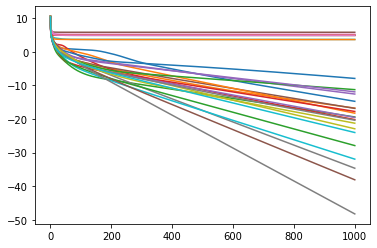

In [19]:
m,n,k = 50,50,5
lmda = 1
(X,y), (A,B,v) = noisy_problem(m,n,k, noise_rate=0.0)
plot_convergence_curves(X,y, lmda, k, num_curves=30, num_iters=1000)

Plot with some noise

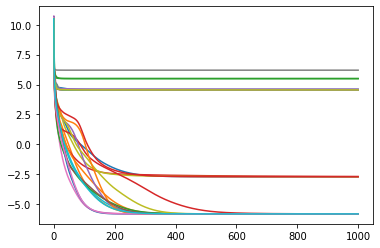

In [20]:
m,n,k = 50,50,5
lmda = 1
(X,y), (A,B,v) = noisy_problem(m,n,k, noise_rate=0.1)
plot_convergence_curves(X,y, lmda, k, num_curves=30, num_iters=1000)

There is quite a bit of interesting behavior. For instance we occassionally see convergence to a cycle.  We also notice that we hit a convergence horizon when our system has noise (as we'd expect).  We also don't see this convergence horizon behavior when our system doesn't have noise.

Nearly of our curves appear to show linear convergence in the limit.  There should hopefully be a theoretical reason for this.

<b> Testing ability of method to perform inference </b>

In [21]:
m,n,k = 100,100,5
training_frac = 0.8

(X_train, X_test), (y_train, y_test) = train_test_data(m,n,k, training_frac)

#training step
(A, B, v), objective_val = do_training(X_train, y_train, lmda=100, k=2, num_iters=100)

#inference step
predicted_y = do_inference(B,X_test,v)

#error analysis
error = np.linalg.norm(predicted_y - y_test)/np.linalg.norm(y_test)
print("Relative Error", error)

Relative Error 0.16777504295481624


<b> Testing on Covid data </b>

In [10]:
#Read in the covid and demographic data
covid_col = demo_data.get_covid_column('Incidence_Rate')
full_yu = demo_data.read_yu_data()
(yu_train,covid_train), (yu_test,covid_test) = demo_data.training_test_data(full_yu, covid_col, test_frac=0.2)
yu_train, covid_train, yu_test, covid_test = yu_train.to_numpy(), covid_train.to_numpy(), yu_test.to_numpy(), covid_test.to_numpy()

In [27]:
(A, B, v), objective_val = do_training(yu_train, covid_train, lmda=100, k=10, num_iters=50)

predicted_covid = do_inference(B,yu_test,v)
error = np.linalg.norm(predicted_covid - covid_test)/np.linalg.norm(covid_test)

print("Relative Error: ", error)
print("True Error: ", np.linalg.norm(predicted_covid - covid_test))
print("covid norm: ", np.linalg.norm(covid_test) )
print("objective: ", objective_val)

Relative Error:  4.740607818040031
True Error:  1.7236867623864285
covid norm:  0.3636003712070563
objective:  1.130154453894106


In [24]:
#Evaluating on training data rather than testing data
(A, B, v), objective_val = do_training(yu_train, covid_train, lmda=100, k=10, num_iters=50)

predicted_covid = do_inference(B,yu_train,v)
error = np.linalg.norm(predicted_covid - covid_train)/np.linalg.norm(covid_train)

print("Relative Error", error)

Relative Error 3.4252927911908233


What does the "learning curve" look like on the covid data?

0
1
2
3
4
5
6
7
8
9


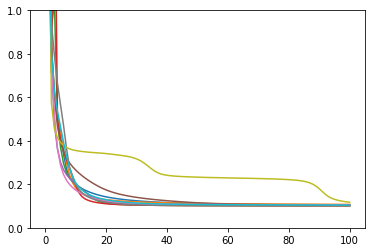

In [19]:
k = 10
lmda = 1000
plt.ylim((0,1))
plot_convergence_curves(yu_train, covid_train, lmda, k, num_curves=10, num_iters=100)

<b>TODO</b>
Testing results as a funtion of iteration.

<b> Questions, Comments </b>

Why does $0$ seem to be an attractor of the iteration?

How robust is this form of inference to the non-uniqueness of NMF? (It should probably be clear that permutation/normalization of topics doesn't matter?)